# Bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib import ticker

# Base de dados

In [5]:
df = pd.read_excel('../Base120.xlsx')

In [6]:
def filtra_por_solucao(df, vet_solucao):
    '''Recebe um vetor solução e retorna o df filtrado para essa solução'''
    stand_prescription_map = {i + 1: vet_solucao[i] for i in range(len(vet_solucao))}
    filtered_df = df[df.apply(lambda row: row['prescrição'] == stand_prescription_map.get(row['talhao']), axis=1)]
    return filtered_df

def calcula_volume(result):
	"""
	Calculate the volume by summing specific columns of a DataFrame.
	This function takes a DataFrame `result` and returns the sum of the values
	in columns 3 to 18 (inclusive).
	Parameters:
	result (pandas.DataFrame): The input DataFrame containing the data.
	Returns:
	pandas.Series: A Series containing the sum of the specified columns.
	"""
	
    
	return result.iloc[:, 3:19].sum()

def calcula_penalidade(volume_anual):
    '''retorna penalidade por volume excedente/faltante (R$500)'''
    upper = []
    lower = []
    for v_ano in volume_anual:
        if v_ano < 140000:
            lower.append(np.abs(v_ano - 140000))
        elif v_ano > 160000:
            upper.append(np.abs(v_ano - 160000))
    return np.sum(upper + lower)*500

def calcula_vpl_aux(result, volume_ano):
    '''Calcula o VPL penalizado (função auxiliar)'''
    return np.sum(result['VPL']) - calcula_penalidade(volume_ano)

def plota_volume(df, vet_sol):
    '''Plota o gráfico do volume nos anos'''
    volume_ano = filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()
    (volume_ano/1000).plot(kind='bar')
    plt.hlines(140, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.hlines(160, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.title("Volume de madeira por ano")
    plt.xlabel("Ano de Produção")
    plt.ylabel("Volume (1000 m$^3$)")

def calcula_volume_aux(df, vet_sol):
	"""
	Calculate the auxiliary volume based on the given solution vector.
	This function filters the DataFrame `df` using the solution vector `vet_sol`
	and then sums the values in columns 3 to 18 (inclusive) of the filtered DataFrame.
	Parameters:
	df (pandas.DataFrame): The input DataFrame containing the data.
	vet_sol (list or array-like): The solution vector used to filter the DataFrame.
	Returns:
	pandas.Series: A Series containing the sum of the values in columns 3 to 18 of the filtered DataFrame.
	"""
    
	return filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()

def calcula_vpl_total(df, vet_solucao):
    '''Calcula o VPL total penalizado'''
    result = filtra_por_solucao(df, vet_solucao)
    volume_ano = calcula_volume(result)
    return calcula_vpl_aux(result, volume_ano)

def encontra_pior_ano(df, sol):
    volume_ano = calcula_volume_aux(df, sol)
    return np.argmax(np.abs(volume_ano-160000)) + 1

def numpy_to_python(obj):
    '''Converte np.int e np.float para int e float dos dados do dicionário'''
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    
def python_to_numpy(dicionario):
    '''Converte int e float para np.int e np.float dos dados do dicionário'''
    for chave, subdict in dicionario.items():
        for subchave, valor in subdict.items():
            if isinstance(valor, int):
                subdict[subchave] = np.int64(valor)
            elif isinstance(valor, float):
                subdict[subchave] = np.float64(valor)
                
    dicionario = {np.int64(key): valor for key, valor in dicionario.items()}
    return dicionario

---

## Alteração na base de dados

In [7]:
df_2 = df.drop_duplicates(subset=['talhao'] + df.columns[3:].tolist(), keep='first')
df_2.to_csv('base_reduzida.csv', index=False)

## Soluções importadas


In [8]:
with open("../solucoes_alpha.json", "r") as arquivo: # soluções geradas por heurística construtiva
    solucoes_alpha = json.load(arquivo)
solucoes_alpha = [np.array(sol) for sol in solucoes_alpha]

In [28]:
import random
import heapq
import math

def gera_vizinhos(df, vet_solucao):
    """
    Gera vizinhos de um talhão sorteado
    """
    talhao_sorteado = random.randint(0, 119)
    prescricao_sorteada = np.random.choice(df[df['talhao'] == talhao_sorteado+1]['prescrição'].unique()) # sorteia prescrição

    vizinho = vet_solucao.copy()
    vizinho[talhao_sorteado] = prescricao_sorteada # altera solução
    return vizinho

def gera_vizinhos_localizado(df, solucao):
    """
    Gera uma lista de vizinhos localizados para uma solução dada.
    Esta função identifica o pior ano em uma solução e, em seguida, encontra
    todos os talhões que podem ser colhidos naquele ano com base nas idades
    de colheita fornecidas.
    Args:
        df (pd.DataFrame): DataFrame contendo informações sobre os talhões,
                             incluindo a idade de cada talhão.
        solucao (list): Lista representando a solução atual.
        idade_colheita (dict): Dicionário onde as chaves são anos e os valores
                               são listas de idades possíveis para colheita
                               naquele ano.
    Returns:
        None: A função imprime o pior ano e os talhões possíveis para colheita
              naquele ano.
    """
    
    idade_colheita = {1: ['5', '6'],
                  2: ['4', '5', '6'],
				  3: ['3', '4', '5'],
				  4: ['2', '3', '4'],
				  5: ['1', '2', '3'],
				  6: ['1', '2', '5', '6'],
				  7: ['1', '4', '5', '6'],
				  8: ['3', '4', '5', '6'],
				  9: ['2', '3', '4', '5', '6'],
				  10: ['1', '2', '3', '4', '5'],
				  11: ['1', '2', '3', '4', '5', '6'],
				  12: ['1', '2', '3', '4', '5', '6'],
				  13: ['1', '2', '3', '4', '5', '6'],
				  14: ['1', '2', '3', '4', '5', '6'],
				  15: ['1', '2', '3', '4', '5', '6'],
				  16: ['1', '2', '3', '4', '5', '6']}
    pior_ano = encontra_pior_ano(df, solucao)
    possiveis_idades = idade_colheita[pior_ano]
    possiveis_talhoes = df[np.isin(df.loc[:, 'idade'], list(map(int, possiveis_idades)))]['talhao'].unique() # talhoes que podem fazer colheita naquele ano
    talhao_sorteado = random.sample(list(possiveis_talhoes), 1) # talhão sorteado
    prescricao_talhao = np.random.choice(df[df['talhao'] == talhao_sorteado[0]]['prescrição'].unique()) # prescrição sorteada
    vizinho = solucao.copy()
    vizinho[talhao_sorteado[0]-1] = prescricao_talhao # altera solução

    return vizinho

def simulated_annealing(df, sol_atual, **kwargs):
    temperatura = kwargs.get('temp_inicial', 1000)
    final_temp = kwargs.get('final_temp', 1)
    cooling_rate = kwargs.get('cooling_rate', 0.9)
    vizinhanca = kwargs.get('vizinhanca', 'aleatoria')
    max_calculos_obj = kwargs.get('max_calculos_obj', 10000)
    max_iter = kwargs.get('max_iter', 100)
    random.seed(kwargs.get('seed', 42))

    counter_calculos_obj, count_aceitou, count_nao_aceitou = 0, 0, 0
    melhor_solucao_global = sol_atual
    melhor_vpl_global = calcula_vpl_total(df, sol_atual)

    while temperatura > final_temp:
        if counter_calculos_obj >= max_calculos_obj:
            print("Número máximo de cálculos atingido")
            break
        for _ in range(max_iter): # número de iterações por temperatura
            if counter_calculos_obj >= max_calculos_obj:
                break
            
            # Geração de vizinhos
            if vizinhanca == 'aleatoria':
                novo_vizinho = gera_vizinhos(df, sol_atual)
            elif vizinhanca == 'localizada':
                novo_vizinho = gera_vizinhos_localizado(df, sol_atual)

            vpl_novo_vizinho = calcula_vpl_total(df, novo_vizinho)
            vpl_atual = calcula_vpl_total(df, sol_atual)
            counter_calculos_obj += 2

            rand = random.random()
            prob = math.exp(-(vpl_atual - vpl_novo_vizinho) / temperatura)
            
            # Aceitação da solução
            if vpl_novo_vizinho > vpl_atual or rand < prob:
                sol_atual = novo_vizinho
                if vpl_novo_vizinho > melhor_vpl_global:
                    melhor_vpl_global = vpl_novo_vizinho
                    melhor_solucao_global = novo_vizinho
                count_aceitou += 1
            else:
                count_nao_aceitou += 1
        temperatura *= cooling_rate
        
    print(f'Temperatura: {temperatura:.2f} | Aceitou: {count_aceitou} | Não aceitou: {count_nao_aceitou}')
    return melhor_vpl_global, melhor_solucao_global

---

In [101]:
class experimento:
    """
    Classe para realizar experimentos e calcular estatísticas sobre os resultados.
    Atributos:
    ----------
    resultados : dict
        Dicionário contendo os resultados dos experimentos.
    media : float
        Média dos resultados.
    maximo : float
        Valor máximo dos resultados.
    minimo : float
        Valor mínimo dos resultados.
    std : float
        Desvio padrão dos resultados.
    estatisticas : dict
        Dicionário contendo as estatísticas calculadas para cada número de cálculos de função objetivo.
    Métodos:
    --------
    __init__(self, resultados):
        Inicializa a classe com os resultados fornecidos.
    calcula_estatisticas(self):
        Calcula as estatísticas (média, máximo, mínimo e desvio padrão) para os resultados fornecidos.
    plota_experimento(self, medida='media'):
        Plota os resultados do experimento com base na medida especificada (padrão é 'media').
    """
    
    def __init__(self, resultados, num_calculos_obj):
        self.resultados = resultados
        self.media = 0
        self.maximo = 0
        self.minimo = 0
        self.std = 0
        self.num_calculos_obj = num_calculos_obj
        self.estatisticas = {num: {'mm': {'media': self.media, 
                                          'maximo': self.maximo, 
                                          'minimo': self.minimo,
                                          'std': self.std},
                                   'pm': {'media': self.media, 
                                          'maximo': self.maximo, 
                                          'minimo': self.minimo,
                                          'std': self.std}} for num in self.num_calculos_obj}
    
    def calcula_estatisticas(self):
        for max_calc, inner in self.resultados.items():
            for k, v in inner.items():
                self.estatisticas[max_calc][k]['media'] = np.mean(v)
                self.estatisticas[max_calc][k]['maximo'] = np.max(v)
                self.estatisticas[max_calc][k]['minimo'] = np.min(v)
                self.estatisticas[max_calc][k]['std'] = np.std(v)

    def plota_experimento(self, medida='media', vizinhanca='Aleatória'):
        x = self.estatisticas.keys()
        medias_mm = []
        medias_pm = []
        for _, inner_dict in self.estatisticas.items():
            for metodo, v in inner_dict.items():
                if metodo == 'mm':
                    medias_mm.append(v[medida])
                if metodo == 'pm':
                    medias_pm.append(v[medida])

        # plt.plot(x, medias_mm, '-o', label='MM')
        plt.plot(x, medias_pm, '-o', label='PM')
            
        plt.xlabel('Número de cálculos de função objetivo', fontsize=12)
        plt.ylabel('VPL', fontsize=12)
        plt.title(f'VPL médio por número de cálculos de função objetivo e vizinhança {vizinhanca}')
        plt.grid(True)
        plt.legend()
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
        plt.ticklabel_format(style='plain', axis='x') 

In [123]:
num_calculos_obj = [5000, 10000, 25000, 50000]
numero_rando_exp = range(15)

# Simulated Annealing

## V1 - Vizinhança aleatória

In [119]:
v1_num_calc_vpl = {num: {'mm': [0], 'pm': []} for num in num_calculos_obj}
max_iter = 20

for iter_experimento in numero_rando_exp:
    print(f'\nExperimento {iter_experimento+1} iniciado')
    for max_calculos_obj in v1_num_calc_vpl.items():
        print(f'\nNúmero de cálculos: {max_calculos_obj[0]}')
        
        calculos_dict = max_calculos_obj[1]
        vpl_sa, sol_sa = simulated_annealing(df_2, solucoes_alpha[2],
                                temp_inicial=100000,
                                final_temp=1,
                                cooling_rate=0.990,
                                vizinhanca='aleatoria',
                                max_calculos_obj=max_calculos_obj[0],
                                max_iter=max_iter,
                                seed=iter_experimento)
        print('Primeiro melhor\nVPL: ', vpl_sa)
        calculos_dict['pm'].append(vpl_sa)



Experimento 1 iniciado

Número de cálculos: 50
Número máximo de cálculos atingido
Temperatura: 98010.00 | Aceitou: 11 | Não aceitou: 14
Primeiro melhor
VPL:  -8481370

Número de cálculos: 100
Número máximo de cálculos atingido
Temperatura: 97029.90 | Aceitou: 15 | Não aceitou: 35
Primeiro melhor
VPL:  -1706850

Número de cálculos: 150
Número máximo de cálculos atingido
Temperatura: 96059.60 | Aceitou: 22 | Não aceitou: 53
Primeiro melhor
VPL:  12094071

Experimento 2 iniciado

Número de cálculos: 50
Número máximo de cálculos atingido
Temperatura: 98010.00 | Aceitou: 8 | Não aceitou: 17
Primeiro melhor
VPL:  -29136932

Número de cálculos: 100
Número máximo de cálculos atingido
Temperatura: 97029.90 | Aceitou: 20 | Não aceitou: 30
Primeiro melhor
VPL:  -9986392

Número de cálculos: 150
Número máximo de cálculos atingido
Temperatura: 96059.60 | Aceitou: 19 | Não aceitou: 56
Primeiro melhor
VPL:  8061373

Experimento 3 iniciado

Número de cálculos: 50
Número máximo de cálculos atingido
Te

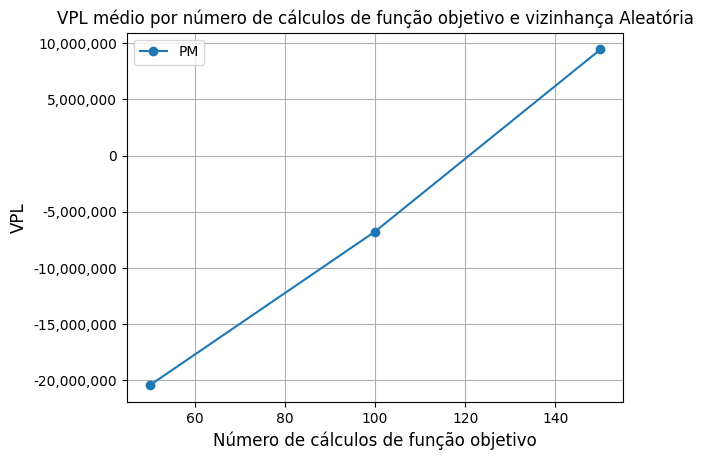

In [120]:
v1 = experimento(v1_num_calc_vpl, num_calculos_obj)
v1.calcula_estatisticas()
v1.plota_experimento(medida='media')

In [ ]:
# Exporta resultados

caminho = 'sa_v1_experimentos.json'
with open(caminho, 'w', encoding='utf-8') as arquivo:
    json.dump(v1_num_calc_vpl, arquivo, ensure_ascii=False, indent=4, default=numpy_to_python)

## V2 - Vizinhança localizada

In [121]:
v2_num_calc_vpl = {num: {'mm': [0], 'pm': []} for num in num_calculos_obj}
max_iter = 20

for iter_experimento in numero_rando_exp:
    print(f'\nExperimento {iter_experimento+1} iniciado')
    for max_calculos_obj in v2_num_calc_vpl.items():
        print(f'\nNúmero de cálculos: {max_calculos_obj[0]}')
        
        calculos_dict = max_calculos_obj[1]
        vpl_sa, sol_sa = simulated_annealing(df_2, solucoes_alpha[2],
                                temp_inicial=100000,
                                final_temp=1,
                                cooling_rate=0.990,
                                vizinhanca='localizada',
                                max_calculos_obj=max_calculos_obj[0],
                                max_iter=max_iter,
                                seed=iter_experimento)
        print('Primeiro melhor\nVPL: ', vpl_sa)
        calculos_dict['pm'].append(vpl_sa)



Experimento 1 iniciado

Número de cálculos: 50
Número máximo de cálculos atingido
Temperatura: 98010.00 | Aceitou: 9 | Não aceitou: 16
Primeiro melhor
VPL:  -1602633

Número de cálculos: 100
Número máximo de cálculos atingido
Temperatura: 97029.90 | Aceitou: 22 | Não aceitou: 28
Primeiro melhor
VPL:  10882675

Número de cálculos: 150
Número máximo de cálculos atingido
Temperatura: 96059.60 | Aceitou: 24 | Não aceitou: 51
Primeiro melhor
VPL:  19568277

Experimento 2 iniciado

Número de cálculos: 50
Número máximo de cálculos atingido
Temperatura: 98010.00 | Aceitou: 14 | Não aceitou: 11
Primeiro melhor
VPL:  -26972906

Número de cálculos: 100
Número máximo de cálculos atingido
Temperatura: 97029.90 | Aceitou: 22 | Não aceitou: 28
Primeiro melhor
VPL:  -2106673

Número de cálculos: 150
Número máximo de cálculos atingido
Temperatura: 96059.60 | Aceitou: 28 | Não aceitou: 47
Primeiro melhor
VPL:  16212706

Experimento 3 iniciado

Número de cálculos: 50
Número máximo de cálculos atingido
T

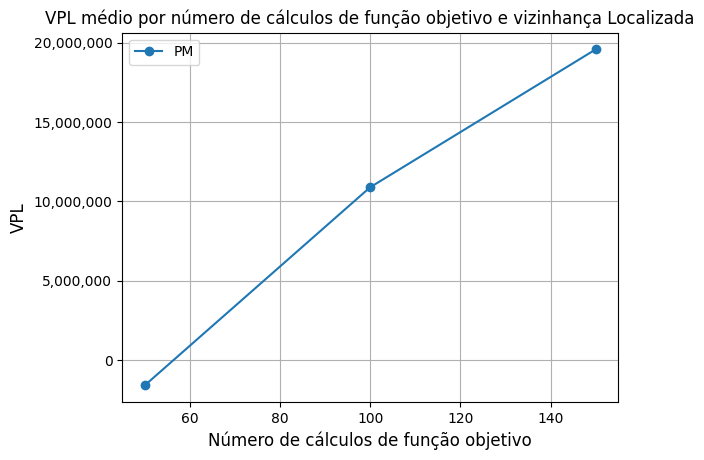

In [122]:
v2 = experimento(v2_num_calc_vpl, num_calculos_obj)
v2.calcula_estatisticas()
v2.plota_experimento(medida='maximo', vizinhanca='Localizada')

In [281]:
# Exporta resultados

caminho = 'sa_v2_experimentos.json'
with open(caminho, 'w', encoding='utf-8') as arquivo:
    json.dump(v2_num_calc_vpl, arquivo, ensure_ascii=False, indent=4, default=numpy_to_python)
    